# Iteration 2 - Create Masking Dataset

> **Dataset**: Client Dataset <br/>
> **Model**: TableNet Model <br/>
> **Creator**: Ryo

In [4]:
import os
import re
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from xml.dom import minidom
from shapely.geometry import Polygon
from shapely.affinity import translate
from tqdm import tqdm
import random

### Global Variabels

In [3]:
json_folder = "../data/tablenet_data/json"
xml_folder = "../data/tablenet_data/xml/2. XML 2.0"

images_folder_1 = "../data/tablenet_data/images/1. Processed"
images_folder_2 = "../data/tablenet_data/images/2. Deskewed"
images_folder_3 = "../data/tablenet_data/images/3. Resized"
images_folder_4 = "../data/tablenet_data/images/4. Cropped"
images_folder_5 = "../data/tablenet_data/images/5. Cropped (Large)"
images_folder_6 = "../data/tablenet_data/images/6. Resized (Large)"

masking_folder_1 = "../data/tablenet_data/masking/1. Original Masks"
masking_folder_2 = "../data/tablenet_data/masking/2. Deskewed Masks"
masking_folder_3 = "../data/tablenet_data/masking/3. Resized Masks"
masking_folder_4 = "../data/tablenet_data/masking/4. Cropped Masks"
masking_folder_5 = "../data/tablenet_data/masking/5. Cropped Masks (Large)"
masking_folder_6 = "../data/tablenet_data/masking/6. Resized Masks (Large)"

# Testing Images

## Rename File

In [5]:
def natural_sort_key(text):
    """
    Generate a sorting key that respects natural numerical ordering.
    For example, "10" will come after "2".
    """
    return [int(part) if part.isdigit() else part.lower() for part in re.split(r'(\d+)', text)]

def rename_files_to_match_original(original_folder, fine_tuned_folder):
    """
    Rename files in the fine-tuned folder to match the filenames in the original folder.

    Parameters:
    - original_folder (str): Path to the folder containing the original files with desired filenames.
    - fine_tuned_folder (str): Path to the folder containing files with the new names to be renamed.

    Returns:
    - None: Files in the fine-tuned folder will be renamed directly.
    """
    # Get all file names from the original folder and sort them naturally
    original_files = sorted(os.listdir(original_folder), key=natural_sort_key)

    # Get all file names from the fine-tuned folder and sort them naturally
    fine_tuned_files = sorted(os.listdir(fine_tuned_folder), key=natural_sort_key)

    # Ensure the number of files in both folders matches
    if len(fine_tuned_files) != len(original_files):
        raise ValueError("The number of files in the fine-tuned folder does not match the original folder!")

    # Rename each file in the fine-tuned folder to match the corresponding original file name
    for fine_tuned_file, original_file in zip(fine_tuned_files, original_files):
        # Construct the full paths for the fine-tuned file and the new file name
        fine_tuned_path = os.path.join(fine_tuned_folder, fine_tuned_file)
        new_fine_tuned_path = os.path.join(fine_tuned_folder, original_file)

        # Rename the file
        os.rename(fine_tuned_path, new_fine_tuned_path)
        print(f"Renamed: {fine_tuned_file} -> {original_file}")

    print("All files have been successfully renamed to match the original filenames!")

In [6]:
# Path to the original folder
original_folder = "../data/data-understanding/2. Non Duplicated (Original)"

# Path to the fine-tuned folder
fine_tuned_folder = "../data/Full_Fine_Tuned_Flow"

# Call the function
rename_files_to_match_original(original_folder, fine_tuned_folder)

Renamed: Fine_Tuned_Flow_Image_Image_1.jpg -> DSC00916.JPG
Renamed: Fine_Tuned_Flow_Image_Image_2.jpg -> DSC00917.JPG
Renamed: Fine_Tuned_Flow_Image_Image_3.jpg -> DSC00918.JPG
Renamed: Fine_Tuned_Flow_Image_Image_4.jpg -> DSC00919.JPG
Renamed: Fine_Tuned_Flow_Image_Image_5.jpg -> DSC00920.JPG
Renamed: Fine_Tuned_Flow_Image_Image_6.jpg -> DSC00921.JPG
Renamed: Fine_Tuned_Flow_Image_Image_7.jpg -> DSC00922.JPG
Renamed: Fine_Tuned_Flow_Image_Image_8.jpg -> DSC00923.JPG
Renamed: Fine_Tuned_Flow_Image_Image_9.jpg -> DSC00925.JPG
Renamed: Fine_Tuned_Flow_Image_Image_10.jpg -> DSC00929.JPG
Renamed: Fine_Tuned_Flow_Image_Image_11.jpg -> DSC00930.JPG
Renamed: Fine_Tuned_Flow_Image_Image_12.jpg -> DSC00931.JPG
Renamed: Fine_Tuned_Flow_Image_Image_13.jpg -> DSC00932.JPG
Renamed: Fine_Tuned_Flow_Image_Image_14.jpg -> DSC00933.JPG
Renamed: Fine_Tuned_Flow_Image_Image_15.jpg -> DSC00934.JPG
Renamed: Fine_Tuned_Flow_Image_Image_16.jpg -> DSC00935.JPG
Renamed: Fine_Tuned_Flow_Image_Image_17.jpg -> DS

## Deskewing

#### *Function*

In [25]:
def calculate_skew(image, max_lines=3):
    """
    Detect vertical lines in the image and calculate their average skew angle.

    Parameters:
    image (numpy array): Grayscale input image.
    max_lines (int): Maximum number of vertical lines to detect and include in calculations.

    Returns:
    float: Average skew angle in degrees between detected vertical lines and a perfectly vertical line.
    """
    if len(image.shape) != 2:
        raise ValueError("Input image must be grayscale.")

    # Adaptive thresholding
    binary = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )

    # Morphological operations to enhance vertical lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 25))
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Canny edge detection
    edges = cv2.Canny(processed, 50, 150, apertureSize=3)

    # Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=100, maxLineGap=20)

    angles = []
    if lines is not None:
        for line in lines[:max_lines]:
            x1, y1, x2, y2 = line[0]
            delta_x = x2 - x1
            delta_y = y2 - y1
            angle = np.arctan2(delta_y, delta_x) * 180 / np.pi
            if abs(angle) > 80:  # Near-vertical lines
                skew_angle = abs(90 - abs(angle))
                angles.append(skew_angle)

    average_skew = np.mean(angles) if angles else 0.0
    return round(average_skew, 2)

In [26]:
def deskew_image(image, skew_angle):
    """
    Deskew the given image by the specified skew angle.

    Parameters:
    image (numpy array): Input image (grayscale or color).
    skew_angle (float): Angle in degrees by which the image is skewed.

    Returns:
    numpy array: Deskewed image.
    """
    h, w = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), skew_angle, 1.0)
    deskewed_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return deskewed_image

In [27]:
def process_images(image_folder, max_lines=3):
    """
    Process and deskew images in a folder, overwriting the original files.

    Parameters:
    image_folder (str): Path to the folder containing source images.
    max_lines (int): Maximum number of vertical lines to consider for skew calculation.

    Returns:
    None
    """
    # Get all image files
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    with tqdm(image_files, desc="Processing images", leave=True, unit="file") as pbar:
        for image_file in pbar:
            input_path = os.path.join(image_folder, image_file)

            # Read the image
            image = cv2.imread(input_path)
            if image is None:
                pbar.set_postfix({"status": f"Skipped {image_file}"})
                continue

            # Calculate skew angle
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            skew_angle = calculate_skew(gray_image, max_lines)

            # Deskew the image
            deskewed_image = deskew_image(image, -skew_angle)

            # Overwrite the original file with deskewed image
            cv2.imwrite(input_path, deskewed_image)
            pbar.set_postfix({"status": f"Processed {image_file}"})

In [28]:
image_folder = "../data/tablenet_data/results/images"

process_images(image_folder)

Processing images: 100%|██████████| 633/633 [31:59<00:00,  3.03s/file, status=Processed DSC01643.JPG]


## Resizing

In [29]:

def resize_images(image_folder, target_width):
    """
    Resize images in the given folder in-place, overwriting the original files while maintaining aspect ratio.

    Args:
        image_folder (str): Path to the folder containing original images.
        target_width (int): Target width for resizing.

    Returns:
        None
    """
    # Process each image in the folder
    for image_file in tqdm(os.listdir(image_folder), desc="Resizing images", unit="image"):
        if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        # Full path to the image
        image_path = os.path.join(image_folder, image_file)

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            tqdm.write(f"Warning: Unable to read {image_file}. Skipping.")
            continue

        # Calculate new dimensions while maintaining aspect ratio
        height, width = image.shape[:2]
        scale = target_width / width  # Calculate scale based on width
        new_width = target_width
        new_height = int(height * scale)
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # Overwrite the original file with the resized image
        cv2.imwrite(image_path, resized_image)

In [30]:
image_folder = "../data/tablenet_data/results/images"
target_width = 2448  # Target width for resizing

resize_images(image_folder, target_width)

Resizing images: 100%|██████████| 633/633 [05:07<00:00,  2.06image/s]


## Cropping

#### *Function*

In [31]:
def crop_images(image_folder, crop_left, crop_right, crop_top, crop_bottom):
    """
    Crop images in the given folder in-place, overwriting the original files.

    Args:
        image_folder (str): Path to the folder containing input images.
        crop_left (int): Number of pixels to crop from the left side.
        crop_right (int): Number of pixels to crop from the right side.
        crop_top (int): Number of pixels to crop from the top side.
        crop_bottom (int): Number of pixels to crop from the bottom side.

    Returns:
        None
    """
    # Process each image in the folder
    for image_file in tqdm(os.listdir(image_folder), desc="Cropping images", unit="image"):
        if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        
        # Full path to the image
        image_path = os.path.join(image_folder, image_file)

        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            tqdm.write(f"Warning: Unable to read {image_file}. Skipping.")
            continue

        # Crop the image
        height, width = image.shape[:2]
        cropped_image = image[crop_top:height-crop_bottom, crop_left:width-crop_right]

        # Overwrite the original file with the cropped image
        cv2.imwrite(image_path, cropped_image)

#### *Implementation*

In [32]:
# Parameters for cropping
crop_left = 388   # Pixels to crop from the left
crop_right = 300  # Pixels to crop from the right
crop_top = 2      # Pixels to crop from the top
crop_bottom = 10  # Pixels to crop from the bottom

# Call the function to crop images in-place
image_folder = "../data/tablenet_data/results/images"
crop_images(image_folder, crop_left, crop_right, crop_top, crop_bottom)

Cropping images: 100%|██████████| 633/633 [01:41<00:00,  6.26image/s]


---

# Training Images

## JSON > XML

### Create XML from JSON

In [3]:
def create_voc_xml(json_file, output_folder):
    """
    Converts a JSON file to VOC XML format, supporting polygons and linestrips.
    """

    # Read the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Initialize the root XML element
    root = ET.Element("annotation")
    
    # Add basic file information
    ET.SubElement(root, "folder").text = "data"  # Default folder name
    ET.SubElement(root, "filename").text = os.path.basename(data["imagePath"])  # Filename from JSON
    ET.SubElement(root, "path").text = data["imagePath"]  # Full path to the image file
    
    # Add image size information
    size = ET.SubElement(root, "size")
    image_width = int(data["imageWidth"])  # Image width from JSON
    image_height = int(data["imageHeight"])  # Image height from JSON
    image_depth = 3  # Assuming RGB images
    ET.SubElement(size, "width").text = str(image_width)
    ET.SubElement(size, "height").text = str(image_height)
    ET.SubElement(size, "depth").text = str(image_depth)
    
    # Add object annotations from JSON
    for shape in data["shapes"]:
        # Create an XML object for each annotation
        obj = ET.SubElement(root, "object")
        ET.SubElement(obj, "name").text = shape["label"]  # Annotation label
        ET.SubElement(obj, "pose").text = "Unspecified"  # Default pose
        ET.SubElement(obj, "truncated").text = "0"  # Default truncated value
        ET.SubElement(obj, "difficult").text = "0"  # Default difficulty value

        # Handle polygon annotations
        if shape["shape_type"] == "polygon":
            polygon = ET.SubElement(obj, "polygon")
            for point in shape["points"]:  # Iterate over polygon points
                vertex = ET.SubElement(polygon, "vertex")
                ET.SubElement(vertex, "x").text = str(int(point[0]))  # x-coordinate
                ET.SubElement(vertex, "y").text = str(int(point[1]))  # y-coordinate

        # Handle linestrip annotations
        elif shape["shape_type"] == "linestrip":
            linestrip = ET.SubElement(obj, "linestrip")
            for point in shape["points"]:  # Iterate over linestrip points
                vertex = ET.SubElement(linestrip, "vertex")
                ET.SubElement(vertex, "x").text = str(int(point[0]))  # x-coordinate
                ET.SubElement(vertex, "y").text = str(int(point[1]))  # y-coordinate

        # Handle rectangle annotations (fallback for bounding boxes)
        elif shape["shape_type"] == "rectangle":
            bndbox = ET.SubElement(obj, "bndbox")
            points = shape["points"]
            xmin = min(point[0] for point in points)  # Minimum x-coordinate
            ymin = min(point[1] for point in points)  # Minimum y-coordinate
            xmax = max(point[0] for point in points)  # Maximum x-coordinate
            ymax = max(point[1] for point in points)  # Maximum y-coordinate
            ET.SubElement(bndbox, "xmin").text = str(int(xmin))
            ET.SubElement(bndbox, "ymin").text = str(int(ymin))
            ET.SubElement(bndbox, "xmax").text = str(int(xmax))
            ET.SubElement(bndbox, "ymax").text = str(int(ymax))
    
    # Format the XML to be human-readable
    xml_str = ET.tostring(root, 'utf-8')  # Convert XML to a string
    parsed_str = minidom.parseString(xml_str).toprettyxml(indent="  ")  # Pretty print the XML
    
    # Save the formatted XML to a file
    xml_filename = os.path.join(output_folder, os.path.splitext(os.path.basename(json_file))[0] + ".xml")
    with open(xml_filename, 'w') as xml_file:
        xml_file.write(parsed_str)

### Process JSON to XML

In [4]:
def process_json_to_xml(json_folder, xml_folder):
    """
    Rename JSON files to retain only the part starting from 'DSC', convert them to VOC XML format,
    and save the XML files in the specified folder with updated names.

    Args:
        json_folder (str): Path to the folder containing JSON files.
        xml_folder (str): Path to the folder where XML files will be saved.

    Returns:
        None
    """
    # Ensure the output folder exists
    os.makedirs(xml_folder, exist_ok=True)

    # List all JSON files in the folder
    json_files = [filename for filename in os.listdir(json_folder) if filename.endswith(".json")]

    # Iterate over JSON files with a progress bar
    for filename in tqdm(json_files, desc="Renaming and converting JSON to XML"):
        json_path = os.path.join(json_folder, filename)

        # Extract the part starting from 'DSC' in the filename
        if "DSC" in filename:
            base_name = filename[filename.index("DSC"):]  # Extract from 'DSC'
        else:
            print(f"Skipping {filename} as it doesn't contain 'DSC'.")
            continue

        # Rename the JSON file
        renamed_json_path = os.path.join(json_folder, base_name)

        # Avoid overwriting files with the same name
        if not os.path.exists(renamed_json_path):
            os.rename(json_path, renamed_json_path)

        # Define the XML output path with the new base name
        xml_name = base_name.replace(".json", ".xml")
        xml_path = os.path.join(xml_folder, xml_name)

        # Convert the renamed JSON file to XML
        create_voc_xml(renamed_json_path, xml_folder)

    print(f"Conversion completed. JSON files renamed and XML files are saved in: {xml_folder}")

In [5]:
process_json_to_xml(json_folder, xml_folder)

Renaming and converting JSON to XML: 100%|██████████| 60/60 [00:01<00:00, 40.85it/s]

Conversion completed. JSON files renamed and XML files are saved in: ../data/tablenet_data/xml/2. XML 2.0


## Create Masking from XML

### Parse XML

In [6]:
def parse_voc_xml(xml_file):
    """
    Parse a VOC XML file to extract annotations for line_row, column, and other labels.

    Args:
        xml_file (str): Path to the VOC XML file.

    Returns:
        tuple: Contains three elements:
            - line_rows (list): List of polygons or linestrip points for line_row.
            - columns (list): List of polygons for columns.
            - other_annotations (dict): Dictionary of other annotations (e.g., year, location).
    """
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Initialize storage for annotations
    line_rows = []  # Stores line_row annotations
    columns = []  # Stores column annotations
    other_annotations = {"year": [], "location": []}  # Stores additional annotations

    # Iterate over all objects in the XML
    for obj in root.findall("object"):
        label = obj.find("name").text  # Get the label name

        # Handle polygon annotations
        polygon = obj.find("polygon")
        if polygon is not None:
            points = [
                (int(pt.find("x").text), int(pt.find("y").text))
                for pt in polygon.findall("vertex")
            ]
            if label == "column":
                columns.append(points)  # Add to columns
            elif label == "line_row":
                line_rows.append(points)  # Add to line_rows
            else:
                other_annotations[label].append(points)  # Add to other annotations

        # Handle linestrip annotations
        linestrip = obj.find("linestrip")
        if linestrip is not None and label == "line_row":
            points = [
                (int(pt.find("x").text), int(pt.find("y").text))
                for pt in linestrip.findall("vertex")
            ]
            line_rows.append(points)  # Add to line_rows

        # Handle bounding box annotations (fallback for rectangular annotations)
        bndbox = obj.find("bndbox")
        if bndbox is not None:
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            if label in other_annotations:
                other_annotations[label].append((xmin, ymin, xmax, ymax))  # Add to other annotations

    # Sort line_rows by the y-coordinate of the first point (for consistency)
    line_rows = sorted(line_rows, key=lambda x: x[0][1])

    return line_rows, columns, other_annotations

### Create Multiple Masks

In [7]:
def create_masks(image_size, line_rows, column_polygons, other_annotations, row_margin=50, column_margin=20):
    """
    Create binary masks for rows, columns, cells, and other annotations (year, location) using Shapely polygons.

    Args:
        image_size (tuple): Dimensions of the image as (height, width).
        line_rows (list): List of polygons or linestrip points for row boundaries.
        column_polygons (list): List of polygons defining column areas.
        other_annotations (dict): Dictionary containing other annotations like "year" and "location".
        row_margin (int): Margin to apply for row masks (reducing top and bottom boundaries).
        column_margin (int): Margin to apply for column masks (reducing left and right boundaries).

    Returns:
        dict: A dictionary containing binary masks for "row", "column", "cell", and other labels (e.g., "year", "location").
    """
    masks = {}

    # Create mask for rows
    row_mask = np.zeros(image_size, dtype=np.uint8)  # Initialize a blank mask
    row_polygons = []  # Store row polygons for intersection
    for i in range(len(line_rows) - 1):  # Iterate through pairs of consecutive rows
        line1 = line_rows[i]  # Upper line
        line2 = line_rows[i + 1]  # Lower line

        # Combine the top and bottom lines into a polygon
        polygon_coords = line1 + line2[::-1]  # Merge line1 and reversed line2
        polygon = Polygon(polygon_coords)  # Create a Shapely polygon

        # Apply row margin (buffer)
        offset_polygon = polygon.buffer(-row_margin, resolution=16)  # Negative buffer to shrink
        if offset_polygon.is_valid and not offset_polygon.is_empty:  # Ensure valid polygon
            row_polygons.append(offset_polygon)  # Store for intersection
            coords = np.array(offset_polygon.exterior.coords, dtype=np.int32)  # Get polygon coordinates
            cv2.fillPoly(row_mask, [coords], color=255)  # Draw the polygon on the mask

    masks["row"] = row_mask  # Add row mask to the dictionary

    # Create mask for columns
    column_mask = np.zeros(image_size, dtype=np.uint8)  # Initialize a blank mask
    column_polygons = [Polygon(polygon_coords) for polygon_coords in column_polygons]  # Convert to Shapely polygons
    valid_column_polygons = []  # Store valid polygons for intersection
    for polygon in column_polygons:  # Iterate through all column polygons
        # Apply column margin (buffer)
        offset_polygon = polygon.buffer(-column_margin, resolution=16)  # Negative buffer to shrink
        if offset_polygon.is_valid and not offset_polygon.is_empty:  # Ensure valid polygon
            valid_column_polygons.append(offset_polygon)  # Store for intersection
            coords = np.array(offset_polygon.exterior.coords, dtype=np.int32)  # Get polygon coordinates
            cv2.fillPoly(column_mask, [coords], color=255)  # Draw the polygon on the mask

    masks["column"] = column_mask  # Add column mask to the dictionary

    # Create mask for cells by intersecting row and column polygons
    cell_mask = np.zeros(image_size, dtype=np.uint8)
    for row_poly in row_polygons:
        for col_poly in valid_column_polygons:
            intersection = row_poly.intersection(col_poly)
            if intersection.is_valid and not intersection.is_empty:  # Ensure valid intersection
                coords = np.array(intersection.exterior.coords, dtype=np.int32)
                cv2.fillPoly(cell_mask, [coords], color=255)

    masks["cell"] = cell_mask  # Add cell mask to the dictionary

    # Create masks for other annotations (e.g., year, location)
    for label, shapes in other_annotations.items():
        mask = np.zeros(image_size, dtype=np.uint8)  # Initialize a blank mask
        for shape in shapes:
            if isinstance(shape, list):  # If the shape is a polygon
                polygon = Polygon(shape)  # Create a Shapely polygon
                coords = np.array(polygon.exterior.coords, dtype=np.int32)  # Get polygon coordinates
                cv2.fillPoly(mask, [coords], color=255)  # Draw the polygon on the mask
            elif isinstance(shape, tuple):  # If the shape is a bounding box
                xmin, ymin, xmax, ymax = shape
                cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color=255, thickness=-1)  # Draw the rectangle
        masks[label] = mask  # Add the mask to the dictionary with the label as key

    return masks  # Return all masks as a dictionary

### Process from Folder

In [8]:
def process_masks_to_labeled_folders(xml_folder, output_folder, row_margin=10, column_margin=0, image_size=None):
    """
    Process all XML files in a folder and generate masks, saving each label's masks in separate subfolders.

    Args:
        xml_folder (str): Path to the folder containing XML files.
        output_folder (str): Path to the base folder for saving labeled masks.
        row_margin (int): Margin for row masks (default: 10).
        column_margin (int): Margin for column masks (default: 0).
        image_size (tuple): Size of the images as (height, width). If None, derive from XML.

    Returns:
        None: Masks are saved in labeled subfolders under the output folder.
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # List all XML files
    xml_files = [f for f in os.listdir(xml_folder) if f.endswith(".xml")]

    # Iterate through all XML files
    for xml_file in tqdm(xml_files, desc="Processing XML files"):
        xml_path = os.path.join(xml_folder, xml_file)

        # Parse the XML file
        line_rows, column_polygons, other_annotations = parse_voc_xml(xml_path)

        # Determine image size if not provided
        if image_size is None:
            image_size = (3672, 4896)  # Default size (example)

        # Generate masks
        masks = create_masks(image_size, line_rows, column_polygons, other_annotations, row_margin, column_margin)

        # Save masks to label-specific folders
        base_name = os.path.splitext(xml_file)[0]  # Get base name of the file
        for label, mask in masks.items():
            # Create subfolder for the label if it doesn't exist
            label_folder = os.path.join(output_folder, label)
            os.makedirs(label_folder, exist_ok=True)

            # Save the mask in the appropriate subfolder
            mask_path = os.path.join(label_folder, f"{base_name}.png")  # Remove label suffix
            cv2.imwrite(mask_path, mask)  # Save the mask as a PNG file

    print(f"All masks have been processed and saved in: {output_folder}")

In [9]:
process_masks_to_labeled_folders(
    xml_folder=xml_folder,
    output_folder=masking_folder_1,
    row_margin=10,
    column_margin=0,
    image_size=(3672, 4896)
)

Processing XML files: 100%|██████████| 60/60 [00:13<00:00,  4.47it/s]

All masks have been processed and saved in: ../data/tablenet_data/masking/1. Original Masks


In [10]:
def combine_masks(mask_year_folder, mask_location_folder, output_folder):
    """
    Combine year and location masks into a single mask with tqdm for progress tracking.

    Args:
        mask_year_folder (str): Path to the folder containing year masks.
        mask_location_folder (str): Path to the folder containing location masks.
        output_folder (str): Path to the folder where combined masks will be saved.

    Returns:
        None
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get the list of mask files
    year_files = sorted(os.listdir(mask_year_folder))
    location_files = sorted(os.listdir(mask_location_folder))

    # Ensure the number of files match
    if len(year_files) != len(location_files):
        print("Error: The number of files in year and location folders does not match.")
        return

    # Combine masks with progress bar
    for year_file, location_file in tqdm(zip(year_files, location_files), total=len(year_files), desc="Combining masks"):
        year_path = os.path.join(mask_year_folder, year_file)
        location_path = os.path.join(mask_location_folder, location_file)

        # Read the year and location masks
        year_mask = cv2.imread(year_path, cv2.IMREAD_GRAYSCALE)
        location_mask = cv2.imread(location_path, cv2.IMREAD_GRAYSCALE)

        if year_mask is None or location_mask is None:
            print(f"Warning: Unable to read {year_file} or {location_file}. Skipping.")
            continue

        # Combine the masks using bitwise OR
        combined_mask = cv2.bitwise_or(year_mask, location_mask)

        # Save the combined mask
        output_path = os.path.join(output_folder, year_file)  # Use the year mask name
        cv2.imwrite(output_path, combined_mask)

In [11]:
combine_masks(
    mask_year_folder="../data/tablenet_data/masking/1. Original Masks/year",
    mask_location_folder="../data/tablenet_data/masking/1. Original Masks/location",
    output_folder="../data/tablenet_data/masking/1. Original Masks/information"
)

Combining masks: 100%|██████████| 60/60 [00:09<00:00,  6.04it/s]


## Visualization

In [12]:
def visualize_masks_by_file(output_folder, num_samples=5):
    """
    Visualize mask images from labeled subfolders, grouped by the same file name.

    Args:
        output_folder (str): Path to the base folder containing labeled subfolders of masks.
        num_samples (int): Number of random files to visualize (default: 5).

    Returns:
        None: Displays the visualizations.
    """
    # Get all labeled subfolders
    label_folders = [os.path.join(output_folder, folder) for folder in os.listdir(output_folder) if os.path.isdir(os.path.join(output_folder, folder))]
    label_names = [os.path.basename(folder) for folder in label_folders]

    # Collect all unique base file names across label subfolders
    file_names = list(
        set(os.path.splitext(f)[0] for folder in label_folders for f in os.listdir(folder) if f.endswith(".png"))
    )

    # Check if there are any files
    if not file_names:
        print("No mask files found in the provided folder.")
        return

    # Adjust the number of samples if there are fewer files than requested
    num_samples = min(num_samples, len(file_names))

    # Randomly select base file names
    sampled_files = random.sample(file_names, num_samples)

    # Visualize each sampled file in a separate figure
    for base_name in sampled_files:
        plt.figure(figsize=(15, 5))  # Adjust figure size dynamically for each file
        
        for col_idx, (label_folder, label_name) in enumerate(zip(label_folders, label_names)):
            mask_path = os.path.join(label_folder, f"{base_name}.png")
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask in grayscale
                plt.subplot(1, len(label_folders), col_idx + 1)  # One row, multiple columns
                plt.imshow(mask, cmap="gray")
                plt.title(label_name.capitalize(), fontsize=12)
                plt.axis("off")
        
        # Add a title for the figure
        plt.suptitle(f"Visualization for: {base_name}", fontsize=16, weight="bold")
        plt.tight_layout()
        plt.show()

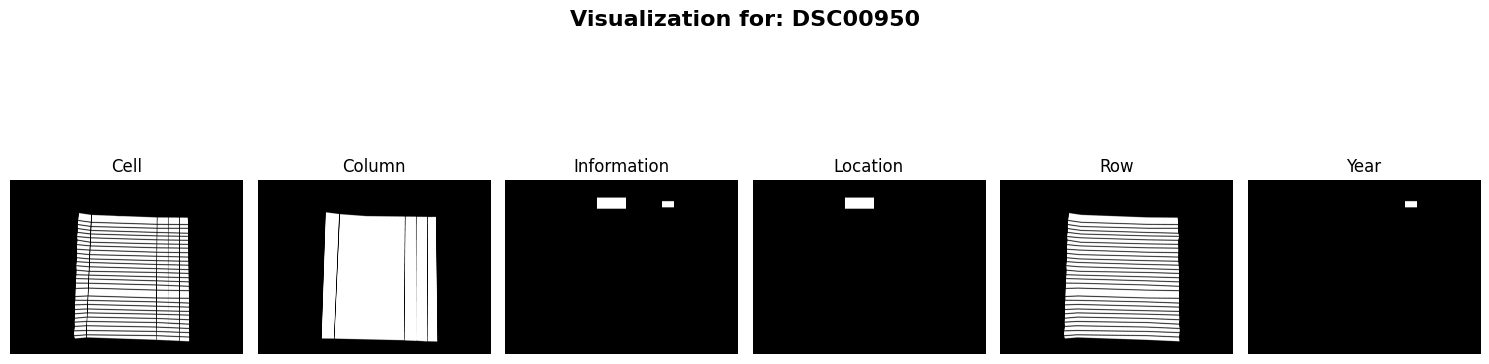

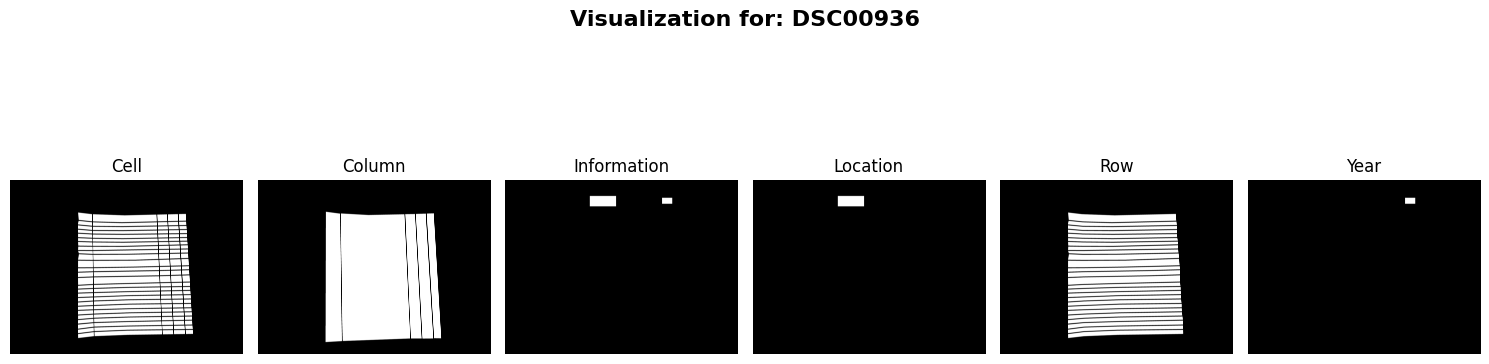

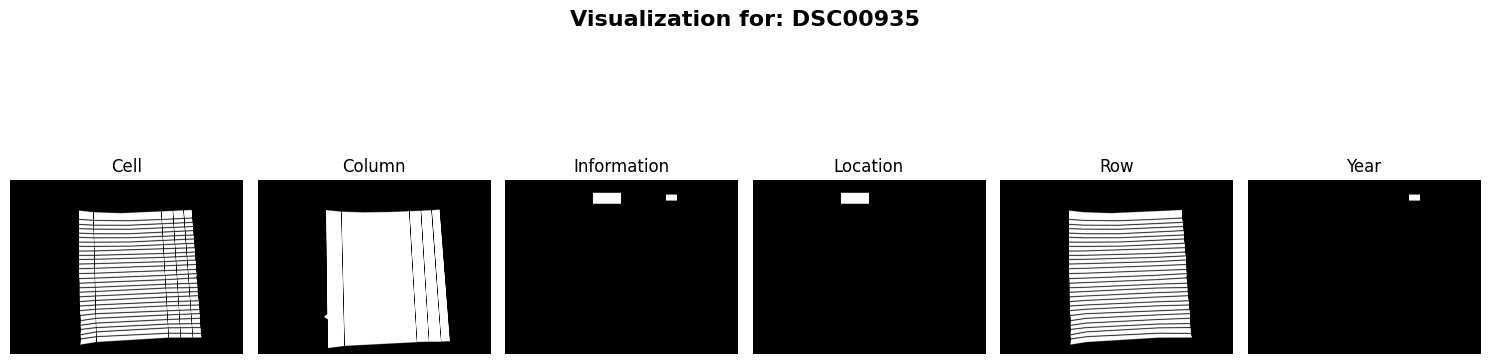

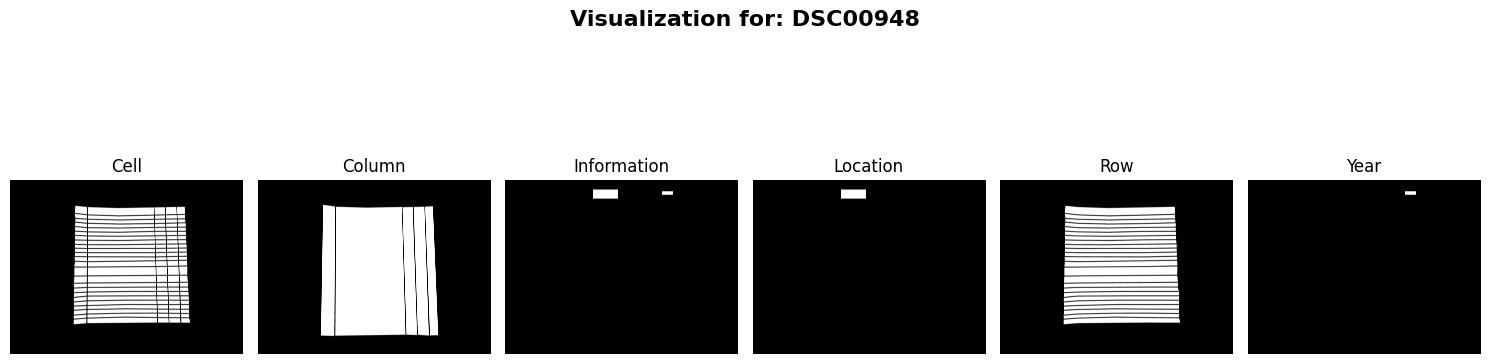

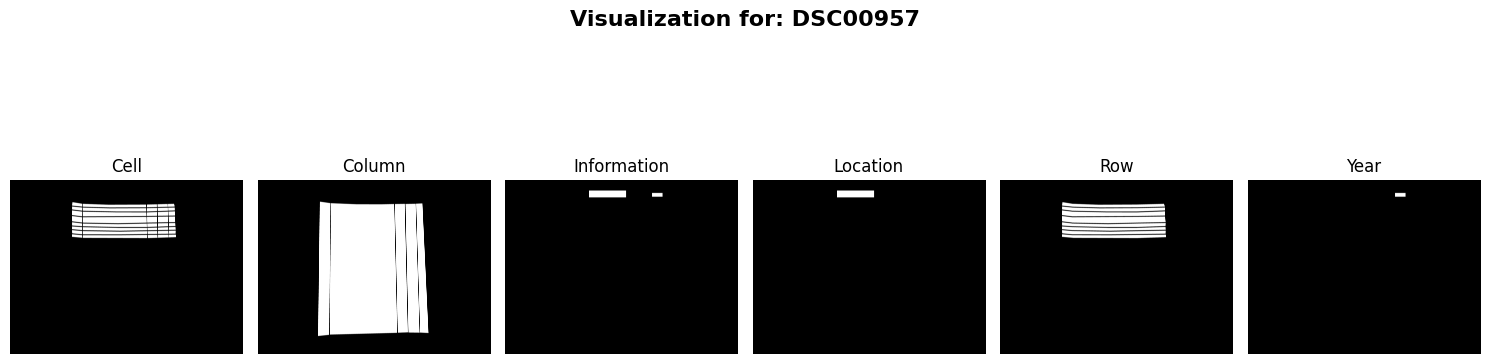

In [13]:
visualize_masks_by_file(masking_folder_1, num_samples=5)

## Deskewing

#### *Function*

In [7]:
def calculate_skew(image, max_lines=3):
    """
    Detect vertical lines in the image and calculate their average skew angle.

    Parameters:
    image (numpy array): Grayscale input image.
    max_lines (int): Maximum number of vertical lines to detect and include in calculations.

    Returns:
    float: Average skew angle in degrees between detected vertical lines and a perfectly vertical line.
    """
    # Validate input image
    if len(image.shape) != 2:
        raise ValueError("Input image must be grayscale.")

    # Step 1: Adaptive thresholding for binary image
    binary = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )

    # Step 2: Morphological operations to enhance vertical lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 25))  # Vertical emphasis
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Step 3: Detect edges using Canny edge detection
    edges = cv2.Canny(processed, 50, 150, apertureSize=3)

    # Step 4: Hough Line Transform to detect vertical lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=100, maxLineGap=20)

    angles = []

    if lines is not None:
        for line in lines[:max_lines]:  # Limit to max_lines
            x1, y1, x2, y2 = line[0]

            # Calculate the angle of the line
            delta_x = x2 - x1
            delta_y = y2 - y1
            angle = np.arctan2(delta_y, delta_x) * 180 / np.pi  # Angle in degrees

            # Filter near-vertical lines (absolute angle close to 90°)
            if abs(angle) > 80:  # Close to vertical
                skew_angle = abs(90 - abs(angle))  # Calculate skew relative to 90°
                angles.append(skew_angle)

    # Calculate the average skew angle
    average_skew = np.mean(angles) if angles else 0.0
    return round(average_skew, 2)

In [15]:
def deskew_image(image, skew_angle):
    """
    Deskew the given image by the specified skew angle.

    Parameters:
    image (numpy array): Input image (grayscale or color).
    skew_angle (float): Angle in degrees by which the image is skewed.

    Returns:
    numpy array: Deskewed image.
    """
    # Get image dimensions
    h, w = image.shape[:2]

    # Calculate rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), skew_angle, 1.0)

    # Perform affine transformation (rotation)
    deskewed_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return deskewed_image

In [16]:
def process_images_and_masks(image_folder, mask_folder, output_image_folder, output_mask_folder, max_lines=3):
    """
    Process and deskew images and their corresponding masks.

    Parameters:
    image_folder (str): Path to the folder containing source images.
    mask_folder (str): Path to the folder containing mask folders (e.g., cell, column, etc.).
    output_image_folder (str): Path to save deskewed images.
    output_mask_folder (str): Path to save deskewed masks.
    max_lines (int): Maximum number of vertical lines to consider for skew calculation.

    Returns:
    None
    """
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_mask_folder, exist_ok=True)

    # Get all mask subfolders
    mask_subfolders = [os.path.join(mask_folder, subfolder) for subfolder in os.listdir(mask_folder) if os.path.isdir(os.path.join(mask_folder, subfolder))]
    all_mask_files = set()

    # Collect all unique file names from mask subfolders
    for subfolder in mask_subfolders:
        mask_files = [os.path.splitext(f)[0] for f in os.listdir(subfolder) if f.lower().endswith('.png')]
        all_mask_files.update(mask_files)

    # Rename and filter image files based on available masks
    image_files = []
    for filename in os.listdir(image_folder):
        if "DSC" in filename:
            base_name = filename[filename.index("DSC"):]  # Extract from 'DSC'
        else:
            print(f"Skipping {filename} as it doesn't contain 'DSC'.")
            continue
        
        # Ensure the file has the correct .JPG extension
        if filename.endswith(".JPG"):
            base_name_with_extension = base_name
        else:
            base_name_with_extension = base_name.replace(".jpg", ".JPG")
        
        renamed_path = os.path.join(image_folder, base_name_with_extension)
        original_path = os.path.join(image_folder, filename)

        # Rename the file if needed
        if not os.path.exists(renamed_path):
            os.rename(original_path, renamed_path)

        # Filter based on mask availability
        if os.path.splitext(base_name)[0] in all_mask_files:
            image_files.append(base_name_with_extension)

    for image_file in tqdm(image_files, desc="Processing images and masks"):
        # Extract main image name without prefix
        main_image_name = os.path.splitext(image_file)[0]

        # Locate masks with matching main name
        corresponding_masks = {}
        for subfolder in mask_subfolders:
            mask_path = os.path.join(subfolder, f"{main_image_name}.png")
            if os.path.exists(mask_path):
                corresponding_masks[subfolder] = mask_path

        input_path = os.path.join(image_folder, image_file)
        output_image_path = os.path.join(output_image_folder, image_file)

        # Read source image
        image = cv2.imread(input_path)
        if image is None:
            print(f"Warning: Unable to read {image_file}. Skipping.")
            continue

        # Calculate skew angle
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        skew_angle = calculate_skew(gray_image, max_lines)

        # Deskew the image
        deskewed_image = deskew_image(image, -skew_angle)
        cv2.imwrite(output_image_path, deskewed_image)

        # Process each mask
        for subfolder, mask_path in corresponding_masks.items():
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Warning: Unable to read mask {mask_path}. Skipping.")
                continue

            deskewed_mask = deskew_image(mask, -skew_angle)

            # Save the deskewed mask
            output_mask_subfolder = os.path.join(output_mask_folder, os.path.basename(subfolder))
            os.makedirs(output_mask_subfolder, exist_ok=True)
            output_mask_path = os.path.join(output_mask_subfolder, f"{main_image_name}.png")
            cv2.imwrite(output_mask_path, deskewed_mask)

In [17]:
process_images_and_masks(images_folder_1, masking_folder_1, images_folder_2, masking_folder_2)

Processing images and masks: 100%|██████████| 60/60 [02:46<00:00,  2.78s/it]


## Resizing

In [8]:
def resize_images_and_masks(image_folder, mask_folder, output_image_folder, output_mask_folder, target_width):
    """
    Resize images and their corresponding masks while maintaining aspect ratio, focusing on width.

    Args:
        image_folder (str): Path to the folder containing original images.
        mask_folder (str): Path to the folder containing mask subfolders.
        output_image_folder (str): Path to the folder where resized images will be saved.
        output_mask_folder (str): Path to the folder where resized masks will be saved.
        target_width (int): Target width for resizing.

    Returns:
        None
    """
    # Create output folders if they don't exist
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_mask_folder, exist_ok=True)

    # Get all mask subfolders
    mask_subfolders = [os.path.join(mask_folder, folder) for folder in os.listdir(mask_folder) if os.path.isdir(os.path.join(mask_folder, folder))]

    # Process images
    for image_file in tqdm(os.listdir(image_folder), desc="Resizing images and masks"):
        if not image_file.endswith(".JPG"):
            continue

        # Resize the original image
        input_image_path = os.path.join(image_folder, image_file)
        output_image_path = os.path.join(output_image_folder, image_file)
        image = cv2.imread(input_image_path)

        if image is None:
            print(f"Warning: Unable to read {image_file}. Skipping.")
            continue

        # Calculate new dimensions while maintaining aspect ratio
        height, width = image.shape[:2]
        scale = target_width / width  # Calculate scale based on width
        new_width = target_width
        new_height = int(height * scale)
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # Save resized image
        cv2.imwrite(output_image_path, resized_image)

        # Process masks corresponding to the current image
        base_name = os.path.splitext(image_file)[0]  # Get the file name without extension
        for subfolder in mask_subfolders:
            mask_file = os.path.join(subfolder, f"{base_name}.png")
            if not os.path.exists(mask_file):
                continue

            # Read and resize the mask
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Warning: Unable to read mask {mask_file}. Skipping.")
                continue

            resized_mask = cv2.resize(mask, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

            # Save resized mask
            output_mask_subfolder = os.path.join(output_mask_folder, os.path.basename(subfolder))
            os.makedirs(output_mask_subfolder, exist_ok=True)
            output_mask_path = os.path.join(output_mask_subfolder, f"{base_name}.png")
            cv2.imwrite(output_mask_path, resized_mask)

In [ ]:
# target_width = 1280                            

# resize_images_and_masks(
#     image_folder=images_folder_2,
#     mask_folder=masking_folder_2,
#     output_image_folder=images_folder_3,
#     output_mask_folder=masking_folder_3,
#     target_width=target_width,
# )

Resizing images and masks: 100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


In [10]:
target_width = 2448                            

resize_images_and_masks(
    image_folder=images_folder_2,
    mask_folder=masking_folder_2,
    output_image_folder=images_folder_3,
    output_mask_folder=masking_folder_3,
    target_width=target_width,
)

Resizing images and masks: 100%|██████████| 60/60 [01:35<00:00,  1.59s/it]


## Cropping

#### *Function*

In [4]:
def crop_images_and_masks(image_folder, mask_folder, output_image_folder, output_mask_folder, crop_left, crop_right, crop_top, crop_bottom):
    """
    Crop images and their corresponding masks.

    Args:
        image_folder (str): Path to the folder containing input images.
        mask_folder (str): Path to the folder containing mask subfolders.
        output_image_folder (str): Path to the folder where cropped images will be saved.
        output_mask_folder (str): Path to the folder where cropped masks will be saved.
        crop_left (int): Number of pixels to crop from the left side.
        crop_right (int): Number of pixels to crop from the right side.
        crop_top (int): Number of pixels to crop from the top side.
        crop_bottom (int): Number of pixels to crop from the bottom side.

    Returns:
        None
    """
    # Create output folders if they don't exist
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_mask_folder, exist_ok=True)

    # Get mask subfolders
    mask_subfolders = [os.path.join(mask_folder, subfolder) for subfolder in os.listdir(mask_folder) if os.path.isdir(os.path.join(mask_folder, subfolder))]

    # Process images
    for image_file in tqdm(os.listdir(image_folder), desc="Cropping images and masks"):
        if not image_file.endswith(".JPG"):
            continue
        
        # Image processing
        input_image_path = os.path.join(image_folder, image_file)
        output_image_path = os.path.join(output_image_folder, image_file)
        image = cv2.imread(input_image_path)

        if image is None:
            print(f"Warning: Unable to read {image_file}. Skipping.")
            continue

        # Crop the image
        height, width = image.shape[:2]
        cropped_image = image[crop_top:height-crop_bottom, crop_left:width-crop_right]

        # Save the cropped image
        cv2.imwrite(output_image_path, cropped_image)

        # Process masks corresponding to the current image
        base_name = os.path.splitext(image_file)[0]  # Get the file name without extension
        for subfolder in mask_subfolders:
            mask_file = os.path.join(subfolder, f"{base_name}.png")
            if not os.path.exists(mask_file):
                continue

            # Read and crop the mask
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Warning: Unable to read mask {mask_file}. Skipping.")
                continue

            cropped_mask = mask[crop_top:mask.shape[0]-crop_bottom, crop_left:mask.shape[1]-crop_right]

            # Save the cropped mask
            output_mask_subfolder = os.path.join(output_mask_folder, os.path.basename(subfolder))
            os.makedirs(output_mask_subfolder, exist_ok=True)
            output_mask_path = os.path.join(output_mask_subfolder, f"{base_name}.png")
            cv2.imwrite(output_mask_path, cropped_mask)

#### *Implementation*

In [14]:
# Parameters for cropping
crop_left = 388   # Pixels to crop from the left
crop_right = 300  # Pixels to crop from the right
crop_top = 2    # Pixels to crop from the top
crop_bottom = 10  # Pixels to crop from the bottom

# Call the function to crop images and masks
crop_images_and_masks(
    image_folder=images_folder_3,
    mask_folder=masking_folder_3,
    output_image_folder=images_folder_4,
    output_mask_folder=masking_folder_4,
    crop_left=crop_left,
    crop_right=crop_right,
    crop_top=crop_top,
    crop_bottom=crop_bottom
)

Cropping images and masks: 100%|██████████| 60/60 [00:33<00:00,  1.81it/s]


910 x 830 tinggi x lebar

896 x 832 tinggi x lebar

## Visualize Image and Masks

In [11]:
def visualize_images_and_masks(image_folder, mask_folder, num_samples=5):
    """
    Visualize original images and their corresponding masks from labeled subfolders.

    Args:
        image_folder (str): Path to the folder containing original images.
        mask_folder (str): Path to the base folder containing labeled subfolders of masks.
        num_samples (int): Number of random files to visualize (default: 5).

    Returns:
        None: Displays the visualizations.
    """
    # Get all labeled subfolders
    label_folders = [os.path.join(mask_folder, folder) for folder in os.listdir(mask_folder) if os.path.isdir(os.path.join(mask_folder, folder))]
    label_names = [os.path.basename(folder) for folder in label_folders]

    # Collect all unique base file names across label subfolders
    file_names = list(
        set(os.path.splitext(f)[0] for folder in label_folders for f in os.listdir(folder) if f.endswith(".png"))
    )

    # Check if there are any files
    if not file_names:
        print("No mask files found in the provided folder.")
        return

    # Adjust the number of samples if there are fewer files than requested
    num_samples = min(num_samples, len(file_names))

    # Randomly select base file names
    sampled_files = random.sample(file_names, num_samples)

    # Visualize each sampled file in a separate figure
    for base_name in sampled_files:
        plt.figure(figsize=(20, 5))  # Adjust figure size dynamically for each file

        # Display the original image
        image_path = os.path.join(image_folder, f"{base_name}.JPG")
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display in matplotlib
            plt.subplot(1, len(label_folders) + 1, 1)  # Add one column for the original image
            plt.imshow(image)
            plt.title("Original Image", fontsize=12)
            plt.axis("off")
        
        # Display masks for the current file
        for col_idx, (label_folder, label_name) in enumerate(zip(label_folders, label_names), start=2):
            mask_path = os.path.join(label_folder, f"{base_name}.png")
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask in grayscale
                plt.subplot(1, len(label_folders) + 1, col_idx)  # One row, multiple columns
                plt.imshow(mask, cmap="gray")
                plt.title(label_name.capitalize(), fontsize=12)
                plt.axis("off")
        
        # Add a title for the figure
        plt.suptitle(f"Visualization for: {base_name}", fontsize=16, weight="bold")
        plt.tight_layout()
        plt.show()

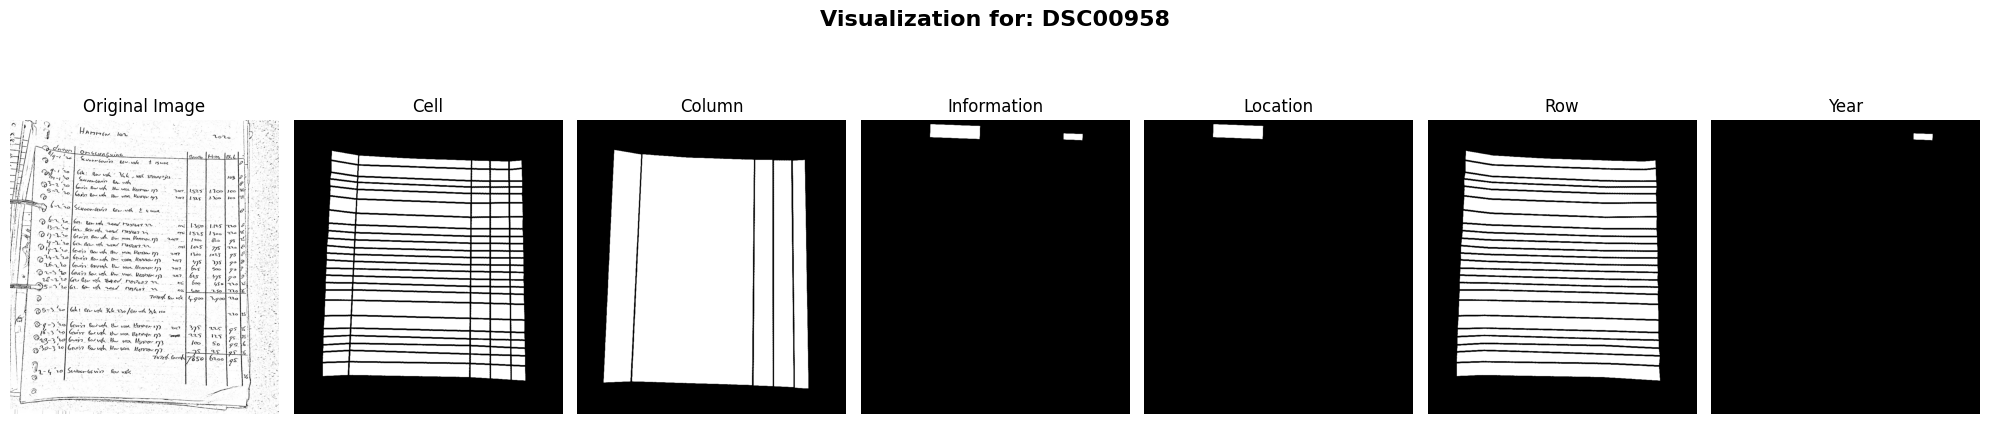

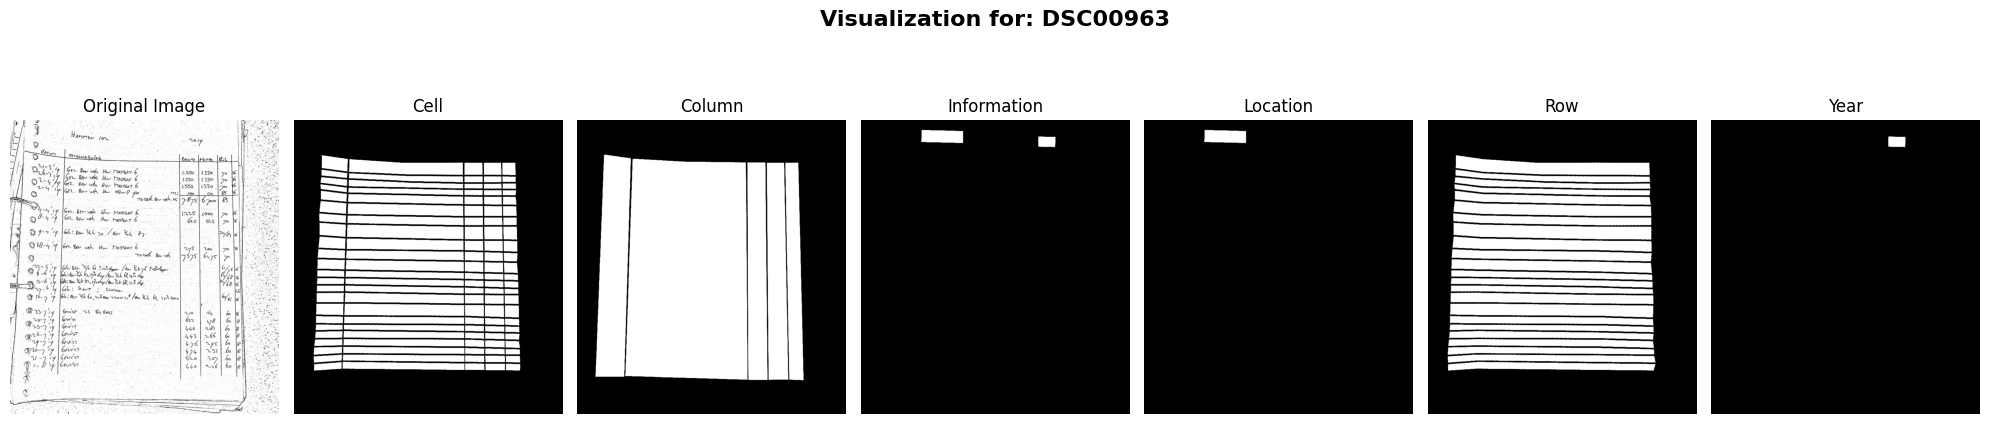

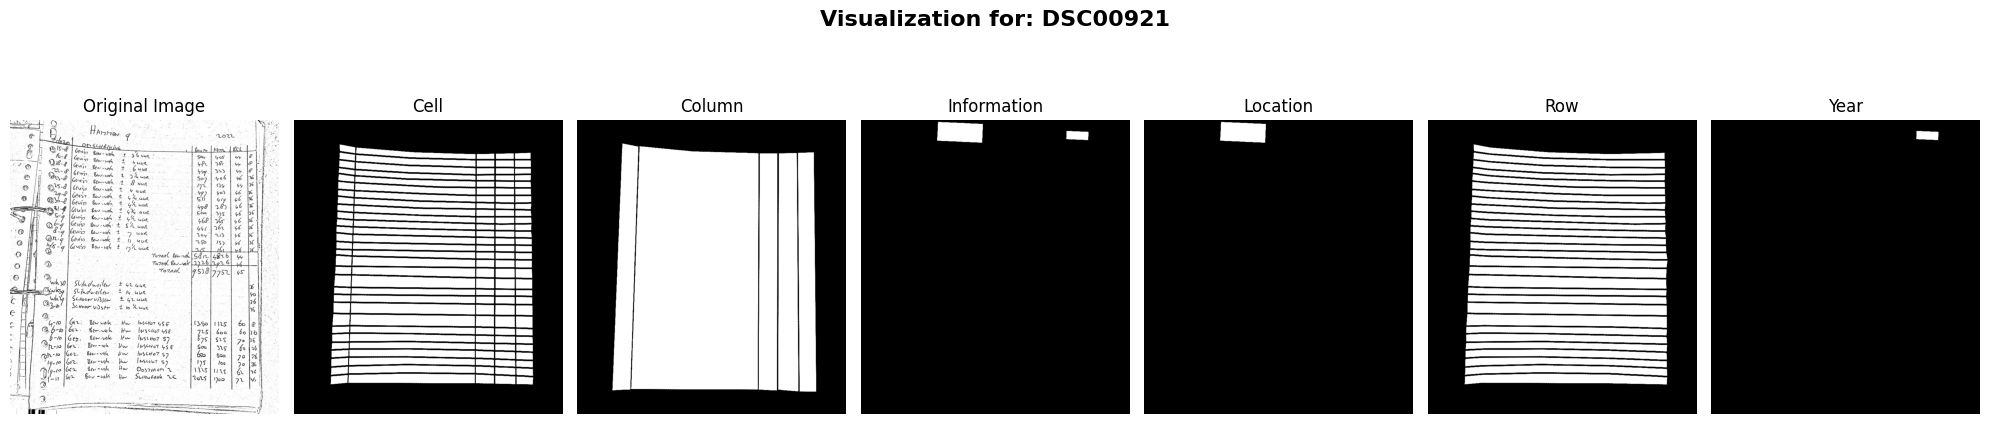

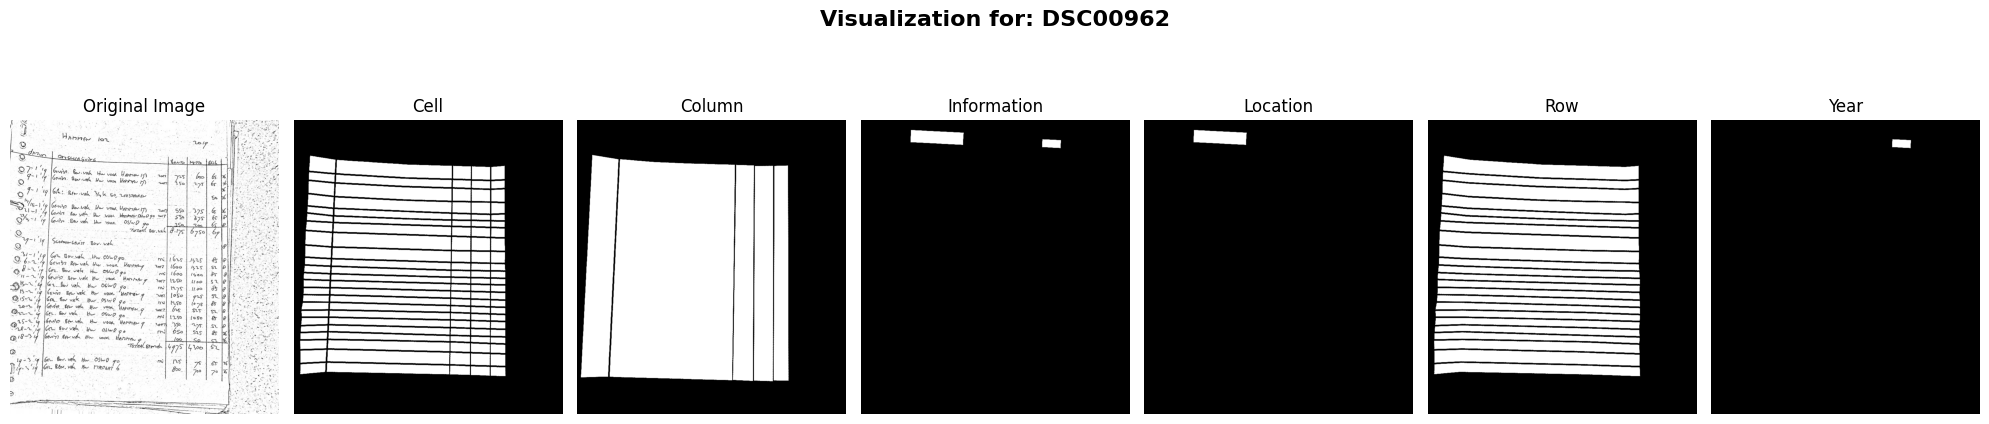

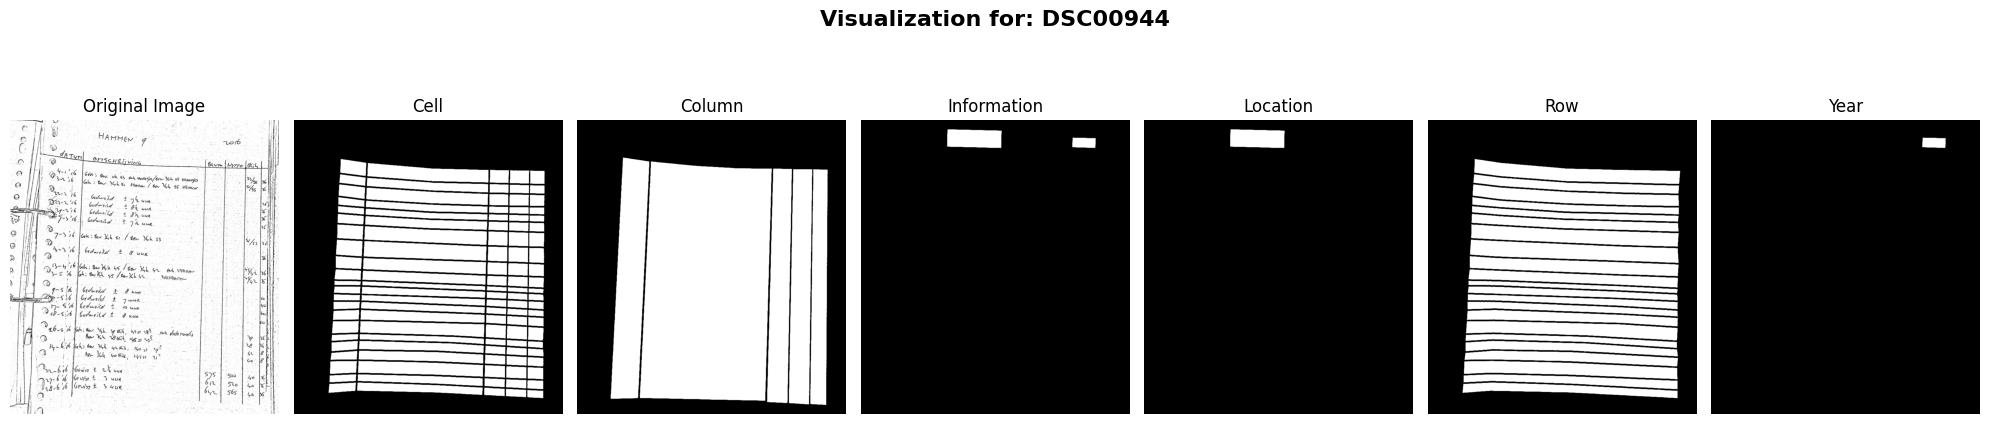

In [12]:
# Call the visualization function
visualize_images_and_masks(images_folder_4, masking_folder_4, 5)